# Transfer Learning using MobileNetV3_Small

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

2022-04-11 14:21:56.363004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 14:21:56.363020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


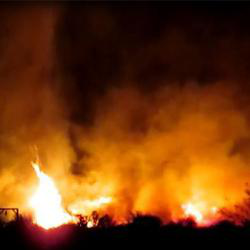

In [4]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

Image input sizes: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [5]:
batch_size = 32
img_height = 224
img_width = 224

# Validation split 80/20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 1520 files belonging to 2 classes.
Using 1216 files for training.


2022-04-11 14:22:01.260487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 14:22:01.260810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 14:22:01.260865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-11 14:22:01.260902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-11 14:22:01.260940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size    
    )


Found 1520 files belonging to 2 classes.
Using 304 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 381 files belonging to 2 classes.


### Get Class Names

In [8]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


### Visualise Data

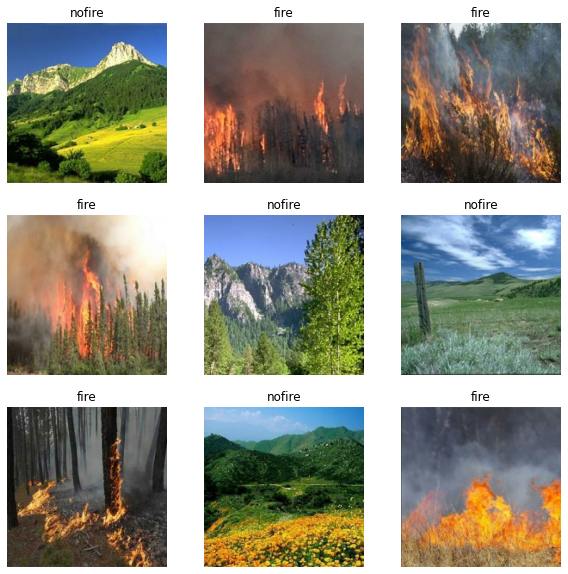

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Create the base model from pre-trained convnets

In [11]:
## By specifying "include_top=False" argument you load a network that doesn't 
## include the classification layers at the top, which is ideal for feature extraction

IMG_SHAPE = (img_width, img_height) + (3,)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True

)


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 576)


## Feature Extraction

In [12]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_4 (ReLU)                 (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 28, 28, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_4[0][0]',             
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 14, 14, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 14, 14, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 14, 14, 144)  3600       ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 14, 14, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 14, 14, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_18 (TFOpL  (None, 7, 7, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_23 (ReLU)                (None, 7, 7, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 7, 7, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 7, 7, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)   0           ['re_lu_30[0][0]']               
 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 7, 7, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 7, 7, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_

## Add classification head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


In [14]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


### Chain together the model

In [15]:
inputs = tf.keras.Input(shape = (IMG_SHAPE))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [16]:
# Useful metrics paper:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")] )

In [17]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 577
Non-trainable par

## Train the model

In [18]:
# Tests the initial base model
initial_epochs = 10
loss0, precision0, recall0, auc0 = model.evaluate(val_ds)

/home/charlie/miniconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 2s 109ms/step - loss: 0.5051 - precision: 0.9263 - recall: 0.5906 - auc: 0.9208


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.51
initial precision: 0.93
initial recall: 0.59
initial auc: 0.92


In [20]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 7s 146ms/step - loss: 0.5236 - precision: 0.8591 - recall: 0.6285 - auc: 0.8638 - val_loss: 0.4456 - val_precision: 0.9478 - val_recall: 0.7315 - val_auc: 0.9672
Epoch 2/10
38/38 [==============================] - 6s 146ms/step - loss: 0.4674 - precision: 0.8703 - recall: 0.7250 - auc: 0.9024 - val_loss: 0.3960 - val_precision: 0.9627 - val_recall: 0.8658 - val_auc: 0.9843
Epoch 3/10
38/38 [==============================] - 6s 145ms/step - loss: 0.4180 - precision: 0.9167 - recall: 0.7921 - auc: 0.9432 - val_loss: 0.3550 - val_precision: 0.9712 - val_recall: 0.9060 - val_auc: 0.9913
Epoch 4/10
38/38 [==============================] - 6s 148ms/step - loss: 0.3778 - precision: 0.9127 - recall: 0.8723 - auc: 0.9631 - val_loss: 0.3210 - val_precision: 0.9790 - val_recall: 0.9396 - val_auc: 0.9947
Epoch 5/10
38/38 [==============================] - 6s 147ms/step - loss: 0.3427 - precision: 0.9391 - recall: 0.9083 - auc: 0.9776 - val_loss: 

### Learning Curves

Found 381 files belonging to 2 classes.


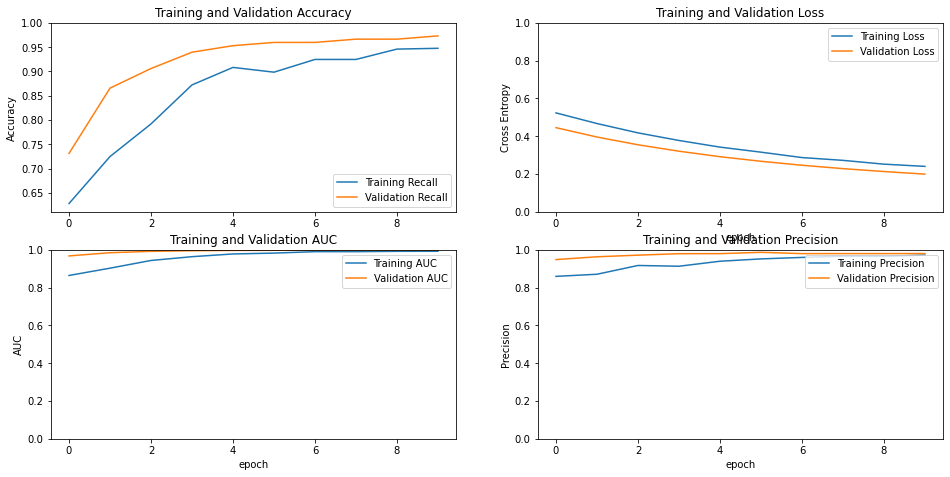

In [21]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




## Fine Tuning

In [22]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetV2 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  229


In [24]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the Model

In [25]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 814,113
Non-trainable

In [26]:
print(len(model.trainable_variables))


75


### Continue Training the Model

In [27]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)


Epoch 10/20
38/38 [==============================] - 14s 269ms/step - loss: 0.1644 - precision: 0.9832 - recall: 0.9591 - auc: 0.9966 - val_loss: 0.0969 - val_precision: 0.9866 - val_recall: 0.9866 - val_auc: 0.9992
Epoch 11/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0915 - precision: 0.9933 - recall: 0.9722 - auc: 0.9992 - val_loss: 0.0625 - val_precision: 0.9803 - val_recall: 1.0000 - val_auc: 0.9994
Epoch 12/20
38/38 [==============================] - 9s 246ms/step - loss: 0.0593 - precision: 0.9950 - recall: 0.9836 - auc: 0.9996 - val_loss: 0.0446 - val_precision: 0.9803 - val_recall: 1.0000 - val_auc: 0.9996
Epoch 13/20
38/38 [==============================] - 9s 247ms/step - loss: 0.0383 - precision: 0.9967 - recall: 0.9918 - auc: 0.9997 - val_loss: 0.0350 - val_precision: 0.9803 - val_recall: 1.0000 - val_auc: 0.9998
Epoch 14/20
38/38 [==============================] - 9s 247ms/step - loss: 0.0252 - precision: 0.9984 - recall: 0.9935 - auc: 1.0000 - val_

### Learning Curves

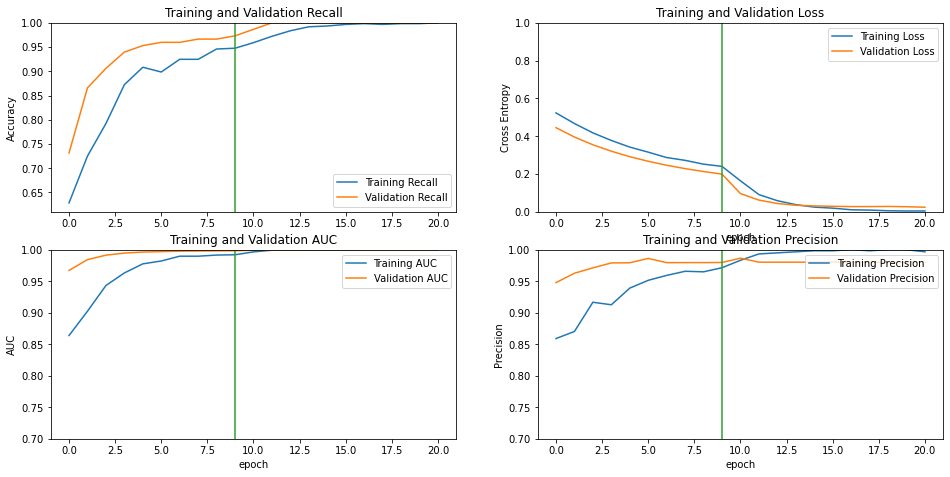

In [28]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Recall')

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




In [29]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )


test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

Found 381 files belonging to 2 classes.


## Verifying on test set

In [30]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

12/12 [==============================] - 1s 114ms/step - loss: 0.0748 - precision: 0.9689 - recall: 0.9791 - auc: 0.9979
Test loss : 0.07478160411119461
Test precision : 0.9689119458198547
Test recall : 0.9790576100349426
Test auc : 0.9979057908058167


In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

In [32]:
print(np.round(predictions, 3))

[1.    1.    1.    0.    1.    1.    0.991 0.    1.    0.997 0.999 1.
 0.993 1.    0.    0.998 1.    0.001 0.    0.    0.001 1.    0.    0.999
 0.    1.    1.    1.    0.959 0.    0.998 1.   ]


In [33]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

tf.Tensor([1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1], shape=(32,), dtype=int32)


Predictions:
 [1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0]
Labels:
 [1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0]


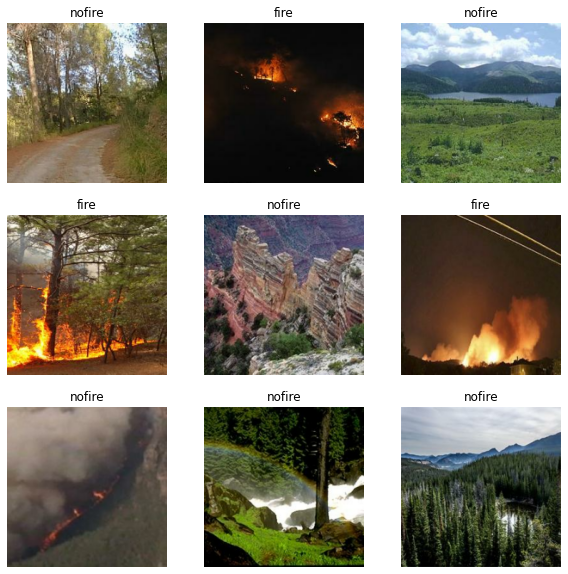

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Saving model

In [9]:
model.save('model00_MobileNetv3_Small.h5')

NameError: name 'model' is not defined

# LOOK AT EXTRACTING THE MISSCLASSIFIED IMAGES AND TALK ABOUT WHY THEY HAVE BEEN MISSCLASSIFIED (SIMILAR FEATURES, LOOKS LIKE A SUNSET ETC)

### Confusion Matrix

In [1]:
def ConfusionMatrix(model = None, dataSet = None):
    
    # Get predictions using dataset and store them in np arrays
    predictions = np.array([]).reshape(0,1)
    labels = np.array([]).reshape(0,1)
    
    for x, y in test_ds:
        predictions = np.concatenate([predictions, model.predict(x)])
        labels = np.concatenate([labels, y.numpy()])
    
    # prepare predictions and labels for Confusion Matrix
    predictions_conf = [1 if x >= 0.5 else 0 for x in predictions.flatten().tolist()]
    labels_conf = labels.flatten().tolist()
    
    # Make confusion matrix
    
    import pandas as pd
    class_names = dataSet.class_names
    con_mat = tf.math.confusion_matrix(labels = labels_conf, predictions=predictions_conf).numpy()
    #con_mat_df = pd.DataFrame(con_mat_norm,
    con_mat_df = pd.DataFrame(con_mat,
                              index = class_names,
                              columns = class_names)
    
    # plot on seaborn
    import seaborn as sns
    figure = plt.figure(figsize = (8, 8))
    sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds, fmt='g')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

Found 381 files belonging to 2 classes.


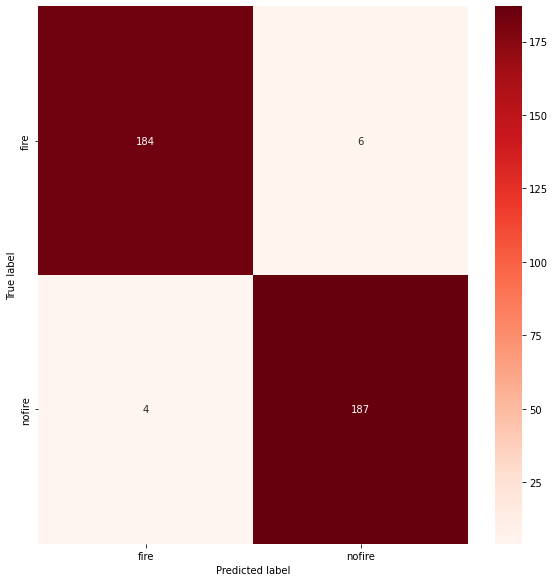

In [10]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
data_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

loaded_model = tf.keras.models.load_model('models/model00_MobileNetv3_Small.h5')
img_height = 224
img_width = 224
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 89787,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'binary'
    )

ConfusionMatrix(loaded_model, test_ds)


## Testing on custom images

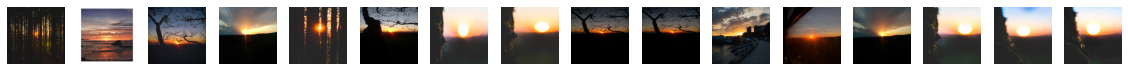

In [57]:
from tensorflow.keras.preprocessing import image
import os

def test_images(img_directory, input_shape):
    preds = []
    false_images = []
    for file in os.listdir(img_directory):
        f = os.path.join(img_directory, file)
        test_image_og = image.load_img(f,
                                    target_size = input_shape)
        test_image = image.img_to_array(test_image_og)
        test_image = np.expand_dims(test_image, axis = 0)
        result = loaded_model.predict(test_image)
        preds.append(result[0][0])
        if result[0][0] < 0.5:
            false_images.append(test_image_og)
    plt.figure(figsize=(20, 20))
    for count, i in enumerate(false_images):
        x = len(false_images)
        ax = plt.subplot(x, x, count + 1)
        plt.imshow(i)
        plt.axis("off")
    return preds

input_shape = (224, 224)
img_directory = '/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Photos-001/'

test_preds = test_images(img_directory, input_shape)

In [58]:
count = 0
for i in test_preds:
    if i>0.5:
        print("no fire")
    else:
        count += 1
        print("fire")
print('Incorrectly predicted ', count,  ' out of ',len(test_preds), '. FPR: ', round(count/len(test_preds), 2))

no fire
fire
no fire
fire
fire
fire
fire
no fire
no fire
no fire
no fire
no fire
fire
fire
fire
fire
no fire
fire
no fire
fire
no fire
no fire
no fire
no fire
fire
no fire
no fire
fire
no fire
fire
fire
fire
no fire
Incorrectly predicted  16  out of  33 . FPR:  0.48


# Feature map extraction

from: https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

In [ ]:
img_path = f'{test_dir}/nofire/abc191.jpg'

In [ ]:
#Iterate thru all the layers of the model
for layer in base_model.layers:
    if 'conv' in layer.name:
        weights = layer.get_weights()
        print(weights)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [ ]:
type(model.layers[1])